In [3]:
%pip install tqdm
%matplotlib inline

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm
from itertools import product
from typing import Union
from statsmodels.graphics.gofplots import qqplot

df = pd.read_excel('./italy_values_dataset.xlsx')

In [3]:
# plot styles
colors = ['#1f77b4', '#2ca02c', '#ff7f0e', '#d62728']

In [4]:
def test_stationarity(series):
    result = adfuller(series.dropna())
    return result[1] < 0.05  # p-value < 0.05 → stazionaria

In [30]:
def best_arma_for_series(series, p_range=(0,3), q_range=(0,3)):
    best_aic = np.inf
    best_order = None
    best_model = None
    y = series.dropna().copy()
    for p in range(p_range[0], p_range[1]+1):
        for q in range(q_range[0], q_range[1]+1):
            if p == 0 and q == 0:
                continue
            try:
                model = ARIMA(y, order=(p,0,q), enforce_stationarity=False, enforce_invertibility=False)
                results = model.fit(disp=False)
                if results.aic < best_aic:
                    best_aic = results.aic
                    best_order = (p, q)
                    best_model = results
            except Exception:
                continue

    return {
        "best_order": best_order,
        "best_aic": best_aic,
        "model": best_model
    }

In [ ]:
def optimize_ARMA(endog: pd.Series, order_list: list) -> pd.DataFrame:
    results = []
    endog = endog["Value"] if isinstance(endog, pd.DataFrame) else endog
    endog = (endog - endog.mean()) / endog.std()  # normalizza

    for order in tqdm(order_list):
        try:
            model = ARIMA(endog,
                        order=(order[0], 0, order[1]),
                        enforce_stationarity=False,
                        enforce_invertibility=False)
            model_fit = model.fit(method_kwargs={'warn_convergence': False})
            
            # scarta risultati instabili (AIC troppo grande o NaN)
            if not pd.isna(model_fit.aic) and abs(model_fit.aic) < 1e6:
                results.append((order, model_fit.aic))

        except Exception:
            continue

    # # se nessun ARMA converge, prova ARIMA con d=1
    # if not results:
    #     print("Nessun modello ARMA convergente, provo ARIMA con d=1")
    #     for order in tqdm(order_list):
    #         try:
    #             model = ARIMA(endog,
    #                         order=(order[0], 1, order[1]),
    #                         enforce_stationarity=False,
    #                         enforce_invertibility=False)
    #             model_fit = model.fit(method_kwargs={'warn_convergence': False})
    #             if not pd.isna(model_fit.aic) and abs(model_fit.aic) < 1e6:
    #                 results.append((order, model_fit.aic))
    #         except Exception:
    #             continue

    # if not results:
    #     print("Nessun modello ARMA/ARIMA convergente per questa serie.")
    #     return pd.DataFrame(columns=["(p,q)", "AIC"])

    result_df = pd.DataFrame(results, columns=["(p,q)", "AIC"])
    result_df = result_df.sort_values(by="AIC", ascending=True).reset_index(drop=True)
    return result_df


In [65]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="statsmodels")

def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int, window: int, method: str, p: int, q: int) -> list:
    total_len = train_len + horizon

    if method == 'mean':
        pred_mean = []
        for i in range(train_len, total_len, window):
            mean = np.mean(df["Value"][:i])
            pred_mean.extend([mean] * window)
        return pred_mean

    elif method == 'last':
        pred_last_value = []
        for i in range(train_len, total_len, window):
            last_value = df["Value"][:i].iloc[-1]
            pred_last_value.extend([last_value] * window)
        return pred_last_value

    elif method == 'ARMA':
        pred_ARMA = []
        for i in range(train_len, total_len, window):
            # controllo: se non ci sono abbastanza osservazioni, salto
            if len(df["Value"][:i]) < 10:
                pred_ARMA.extend([np.nan] * window)
                continue
            try:
                model = ARIMA(df["Value"][:i], order=(p,0,q), enforce_stationarity=False, enforce_invertibility=False)
                res = model.fit()
                predictions = res.get_prediction(start = i, end = i + window - 1)
                oos_pred = predictions.predicted_mean
                pred_ARMA.extend(oos_pred)
            except Exception as e:
                print(f"Errore ARMA per finestra {i}: {e}")
                pred_ARMA.extend([np.nan] * window)
        return pred_ARMA

========================= STAZIONARIA ========================
Agricultural raw materials exports (% of merchandise exports) 63 0.3196178163538349


100%|██████████| 16/16 [00:02<00:00,  6.22it/s]


Miglior ARMA(1, 3) con AIC=-7.553


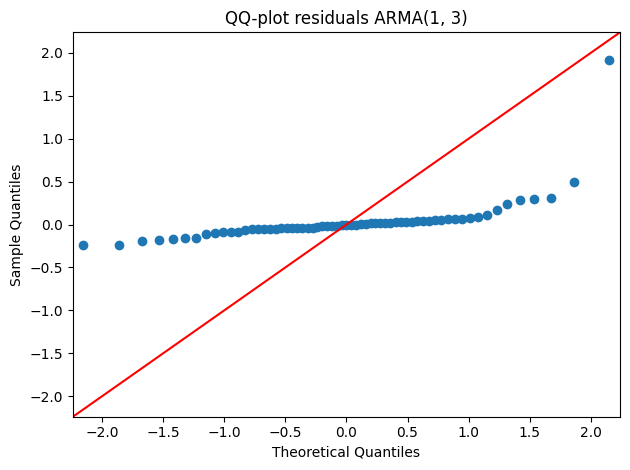

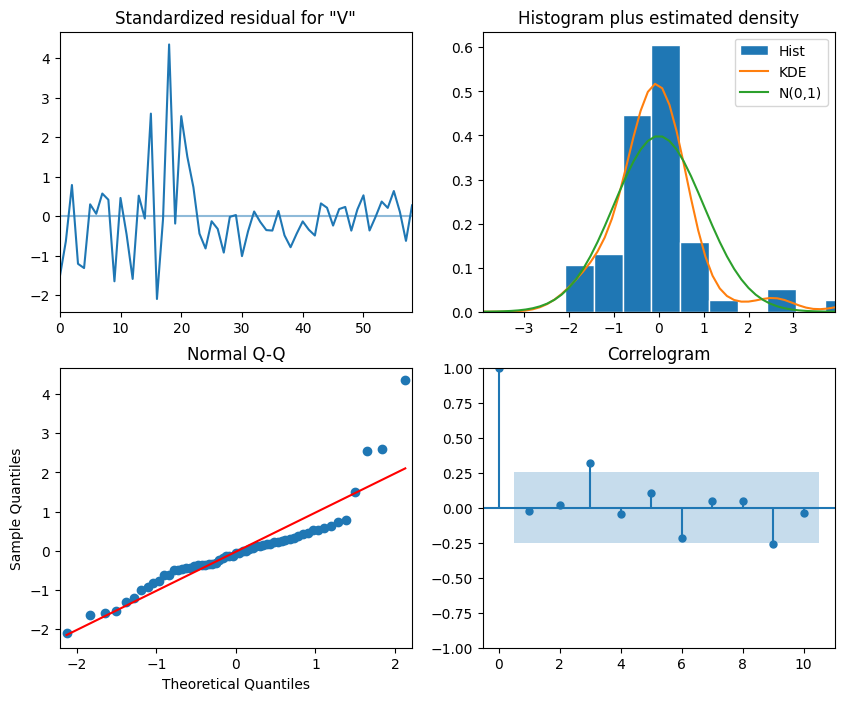

    Year     Value  pred_mean  pred_last_value  pred_ARMA
50  2012  0.730070   1.158567         0.731385   0.687239
51  2013  0.715549   1.158567         0.731385   0.643273
52  2014  0.686465   1.141807         0.715549   0.711570
53  2015  0.706719   1.141807         0.715549   0.685726
54  2016  0.721962   1.125317         0.706719   0.649762


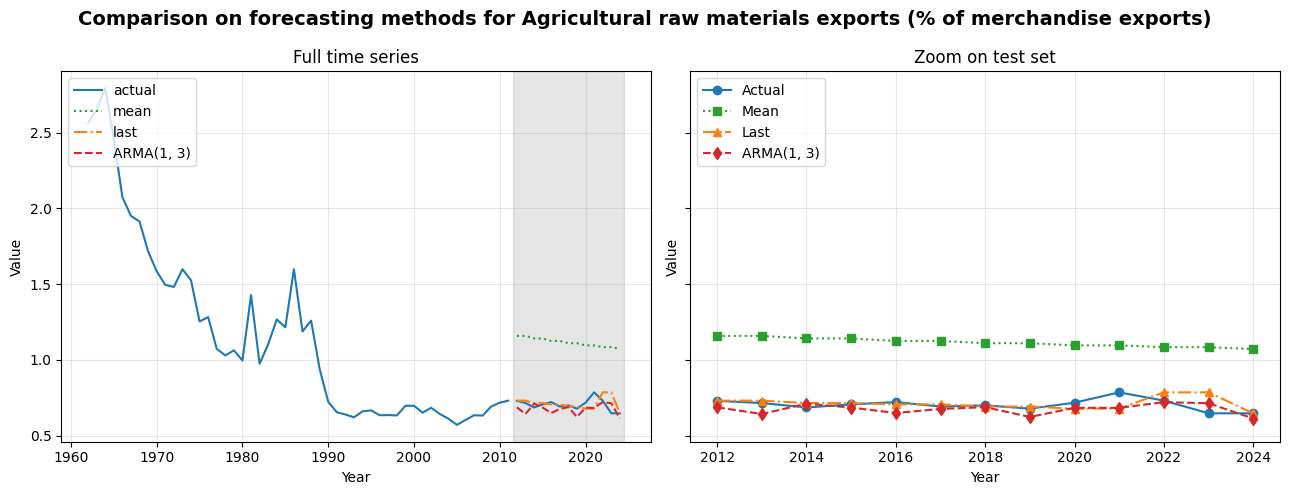

MAE -> mean: 0.411, last: 0.034, AR(2): 0.043
MSE -> mean: 0.170, last: 0.003, AR(2): 0.003


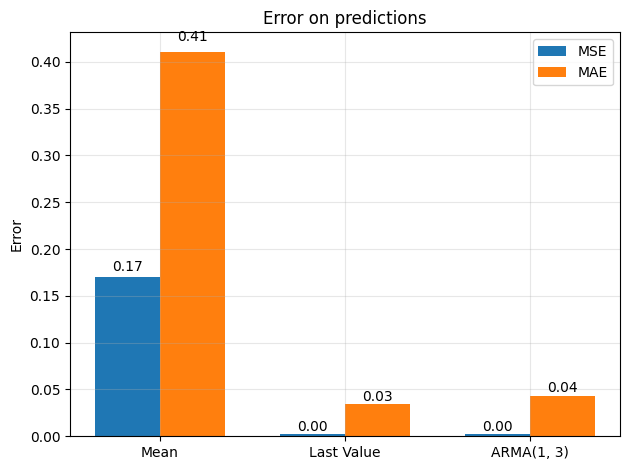

========================= STAZIONARIA ========================
Agricultural raw materials imports (% of merchandise imports) 63 15.400017120683502


100%|██████████| 16/16 [00:02<00:00,  5.56it/s]


Miglior ARMA(2, 2) con AIC=-73.651


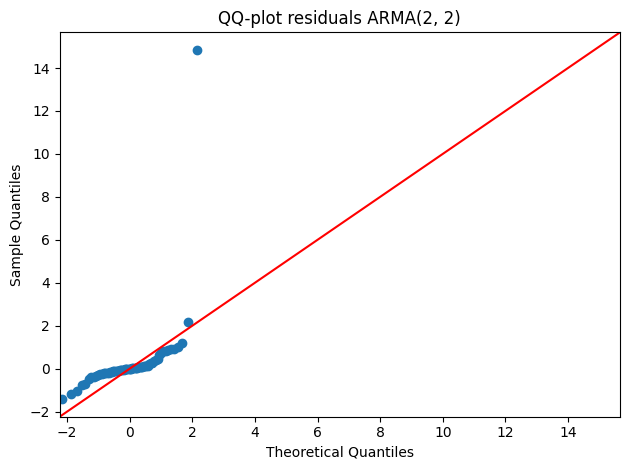

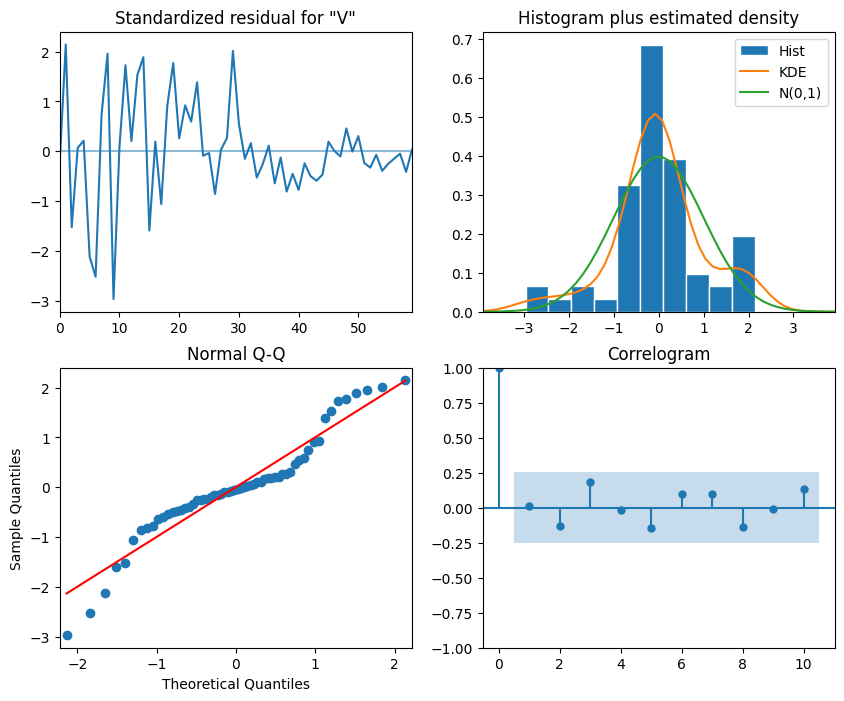

    Year     Value  pred_mean  pred_last_value  pred_ARMA
50  2012  2.168217   6.886714         2.333300   2.254204
51  2013  2.364071   6.886714         2.333300   2.282892
52  2014  2.371093   6.709000         2.364071   2.418802
53  2015  2.325614   6.709000         2.364071   2.279789
54  2016  2.231932   6.547494         2.325614   2.385484


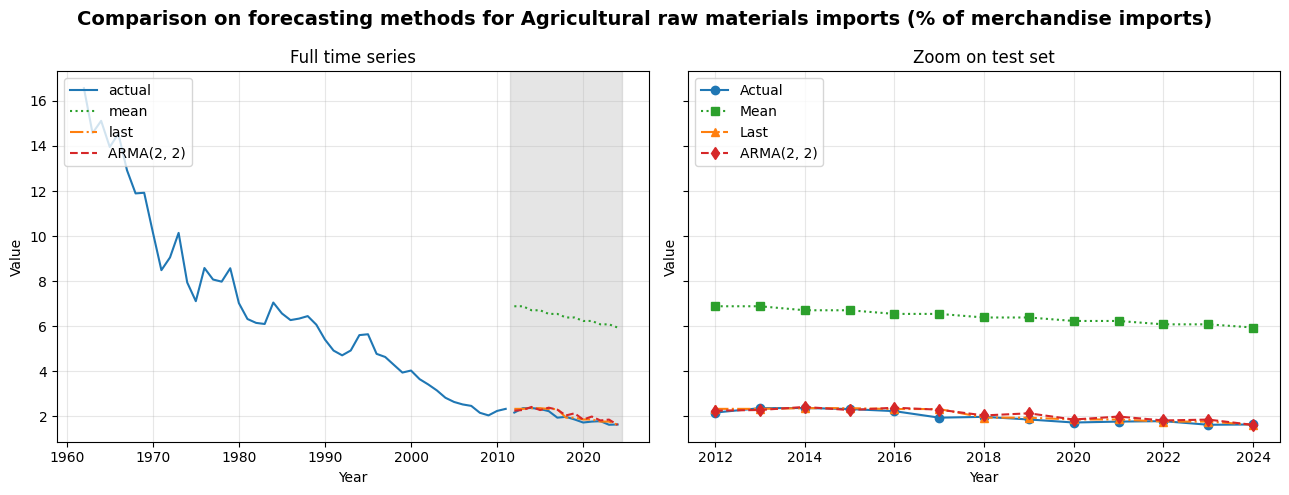

MAE -> mean: 4.450, last: 0.095, AR(2): 0.134
MSE -> mean: 19.816, last: 0.018, AR(2): 0.028


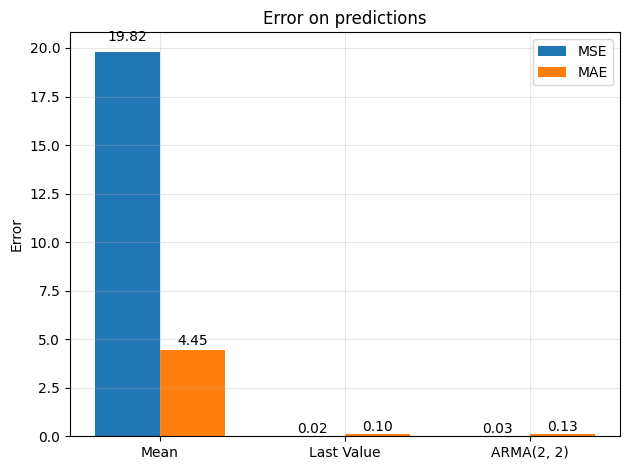

========================= STAZIONARIA ========================
Employment in agriculture (% of total employment) (modeled ILO estimate) 33 1.8763529759157695


100%|██████████| 16/16 [00:02<00:00,  6.69it/s]


Miglior ARMA(3, 0) con AIC=-41.852


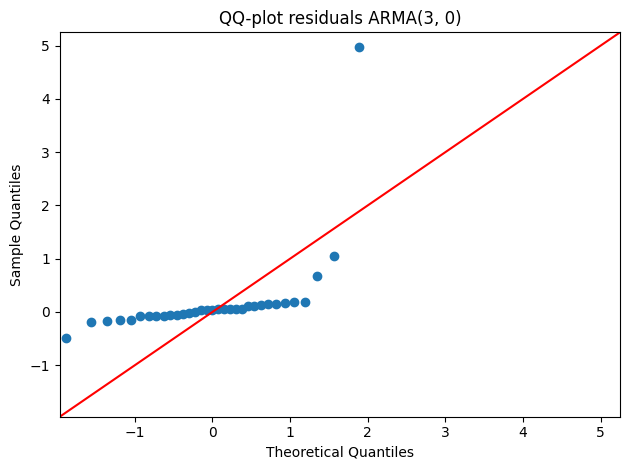

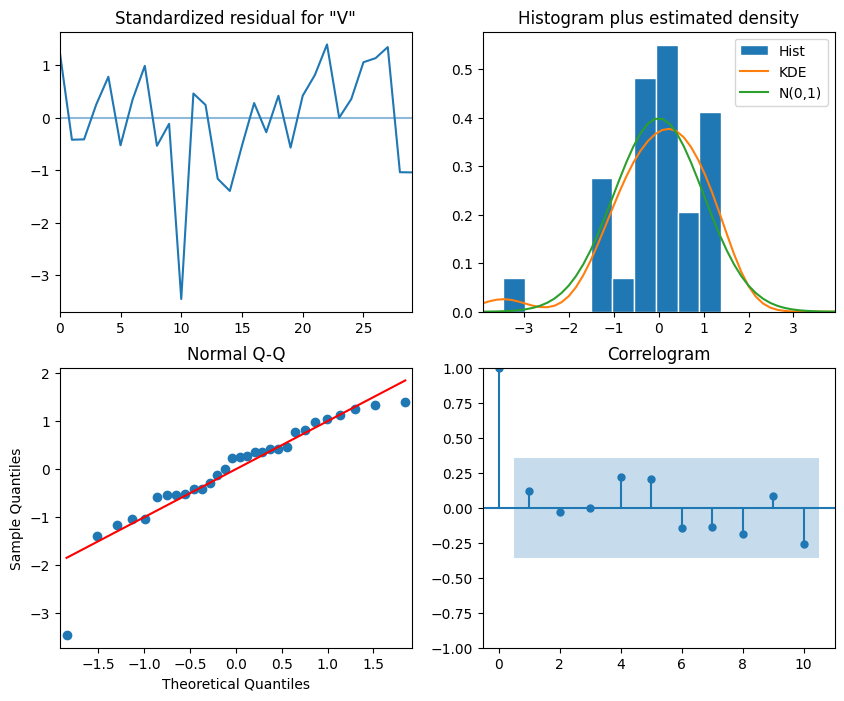

    Year     Value  pred_mean  pred_last_value  pred_ARMA
26  2017  3.782819   5.010655         3.884447   3.740719
27  2018  3.756879   5.010655         3.884447   3.657483
28  2019  3.889869   4.922026         3.756879   3.727382
29  2020  3.981957   4.922026         3.756879   3.682619
30  2021  4.050170   4.856286         3.981957   3.861333


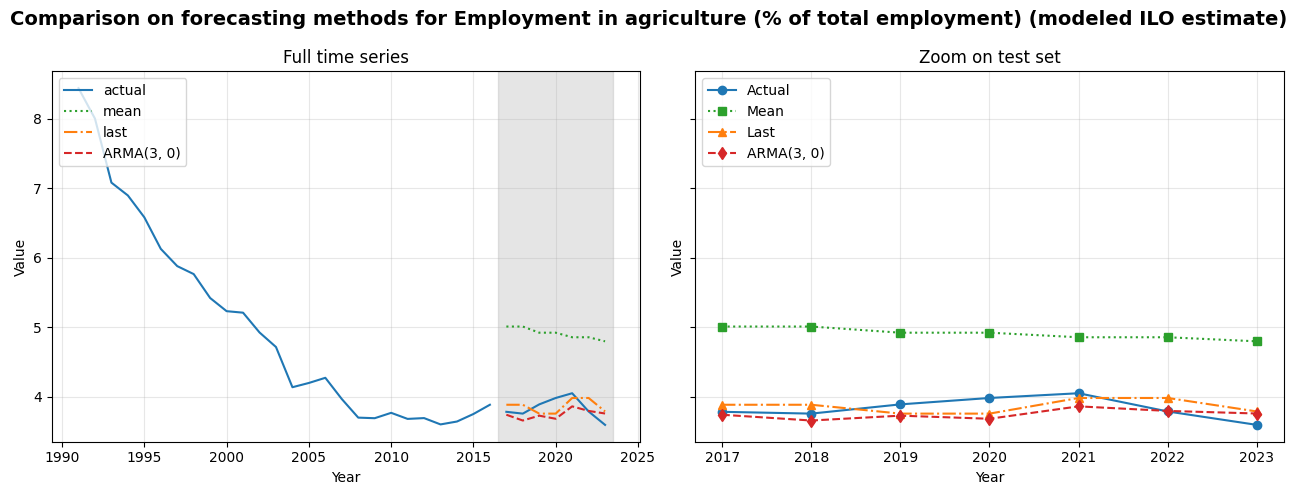

MAE -> mean: 1.076, last: 0.149, AR(2): 0.138
MSE -> mean: 1.181, last: 0.025, AR(2): 0.027


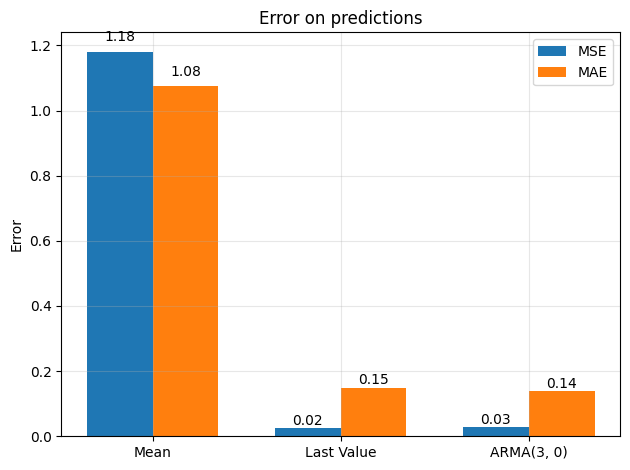

========================= STAZIONARIA ========================
Employment in agriculture, male (% of male employment) (modeled ILO estimate) 33 1.0696533140039324


100%|██████████| 16/16 [00:02<00:00,  7.43it/s]


Miglior ARMA(2, 3) con AIC=-19.935


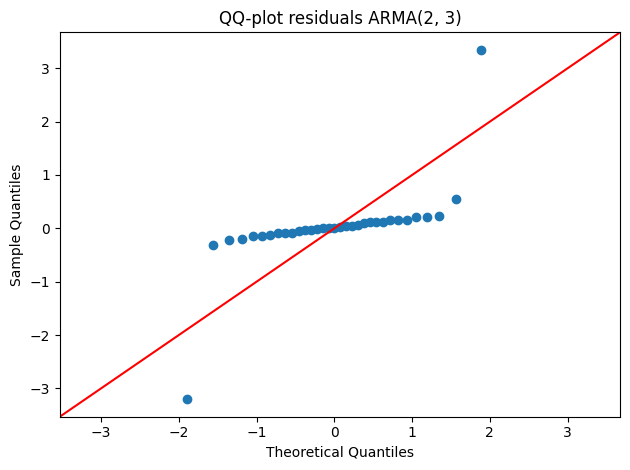

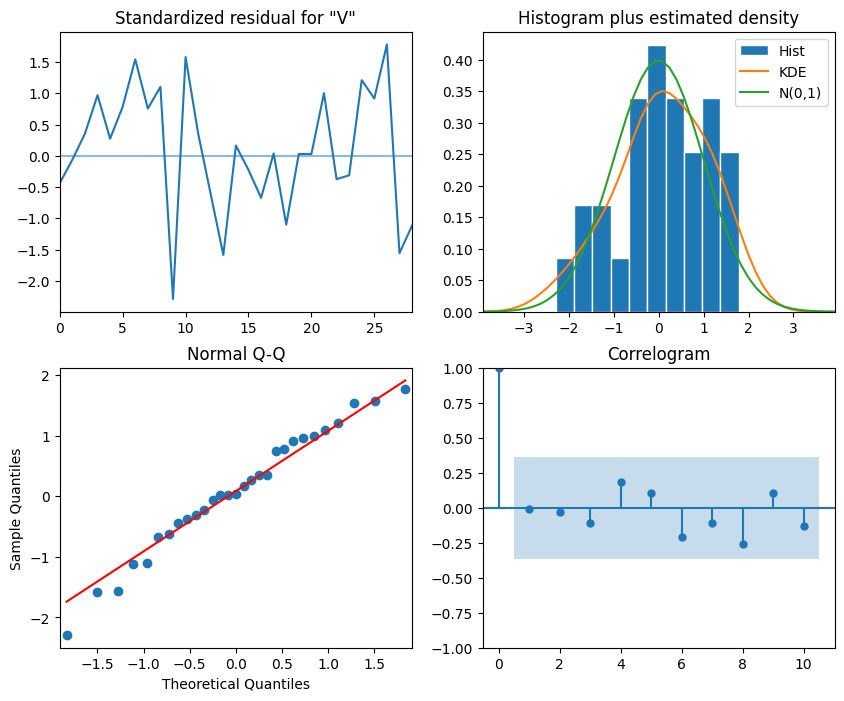

    Year     Value  pred_mean  pred_last_value  pred_ARMA
26  2017  4.814398   5.510566         4.863903   4.975296
27  2018  4.739735   5.510566         4.863903   5.097626
28  2019  4.985230   5.458173         4.739735   4.863412
29  2020  5.106434   5.458173         4.739735   4.982067
30  2021  5.191661   5.430683         5.106434   5.156785


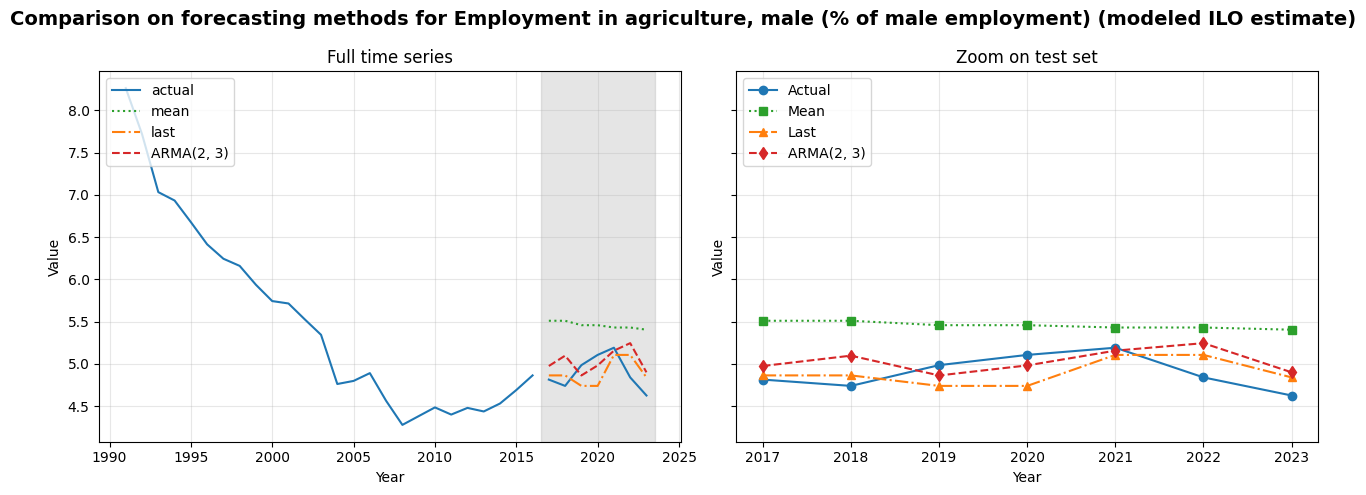

MAE -> mean: 0.557, last: 0.193, AR(2): 0.211
MSE -> mean: 0.348, last: 0.048, AR(2): 0.061


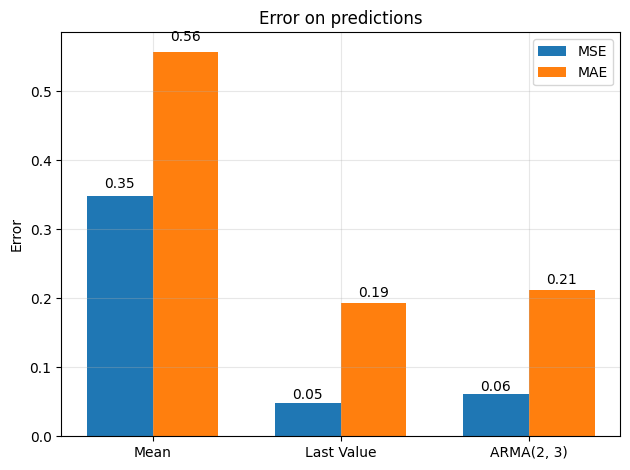

========================= STAZIONARIA ========================
Employment in agriculture, female (% of female employment) (modeled ILO estimate) 33 3.5106087164625923


100%|██████████| 16/16 [00:02<00:00,  5.74it/s]


Miglior ARMA(1, 2) con AIC=-68.202


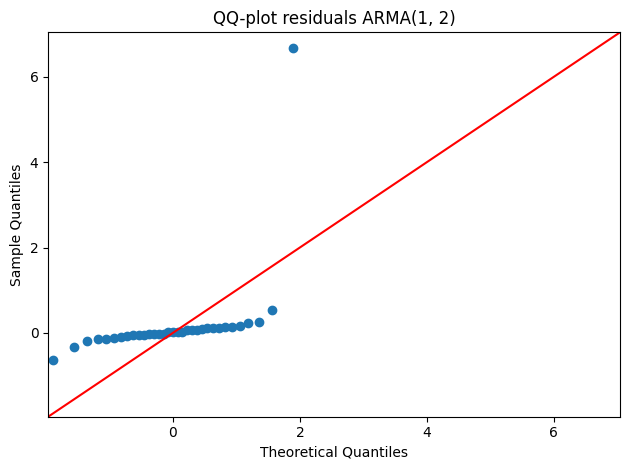

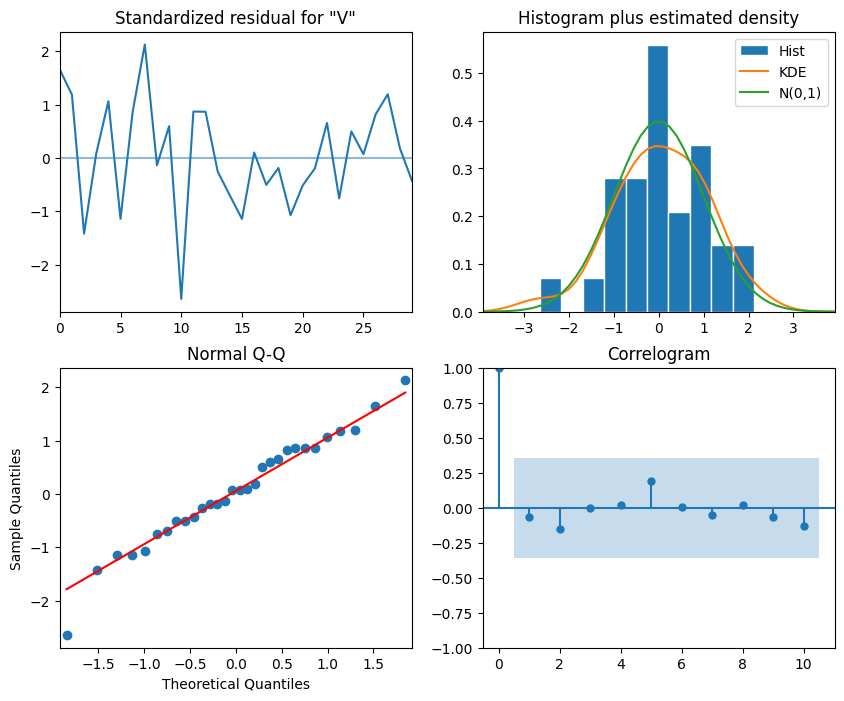

    Year     Value  pred_mean  pred_last_value  pred_ARMA
26  2017  2.350222   4.251096         2.517193   2.367288
27  2018  2.392978   4.251096         2.517193   2.273790
28  2019  2.378808   4.116847         2.392978   2.298174
29  2020  2.414602   4.116847         2.392978   2.234873
30  2021  2.468996   4.002170         2.414602   2.294693


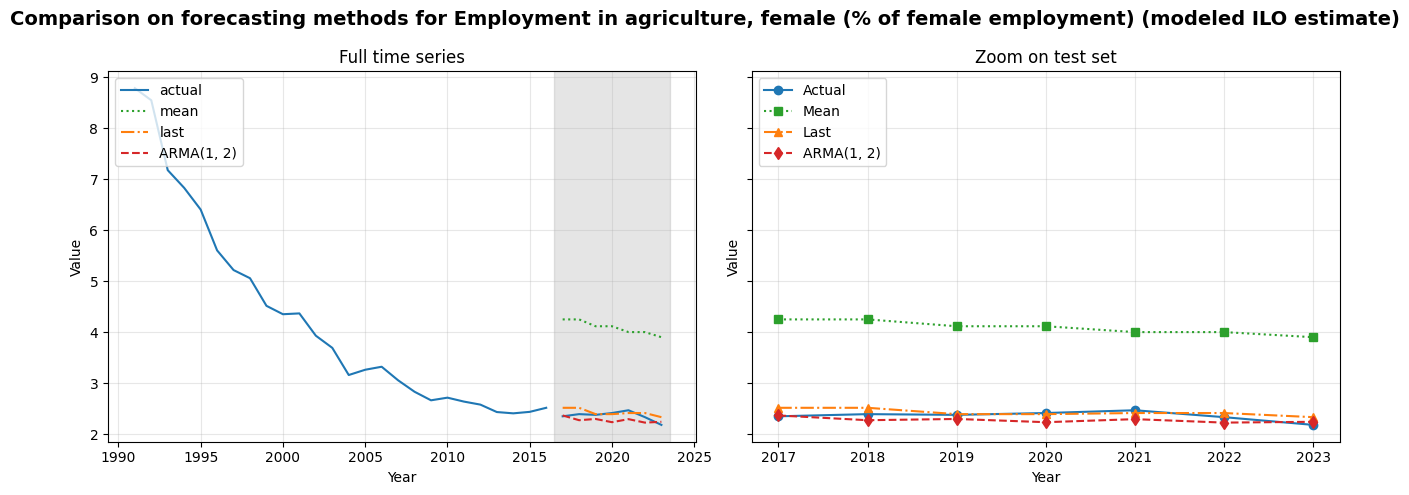

MAE -> mean: 1.732, last: 0.088, AR(2): 0.106
MSE -> mean: 3.011, last: 0.011, AR(2): 0.014


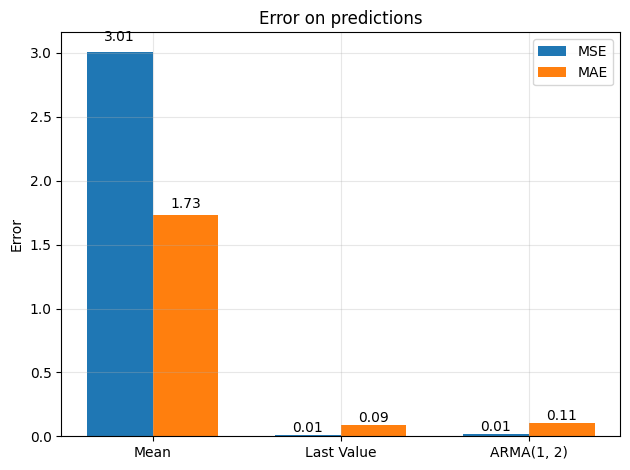

========================= STAZIONARIA ========================
Forest area (% of land area) 33 4.292074387606926


100%|██████████| 16/16 [00:03<00:00,  4.76it/s]


Miglior ARMA(1, 0) con AIC=-186.393


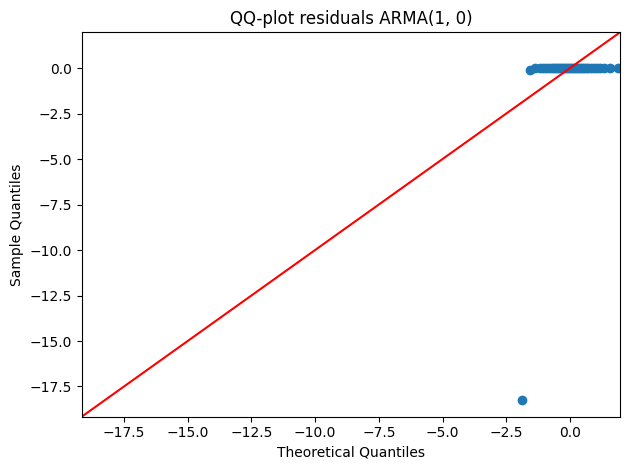

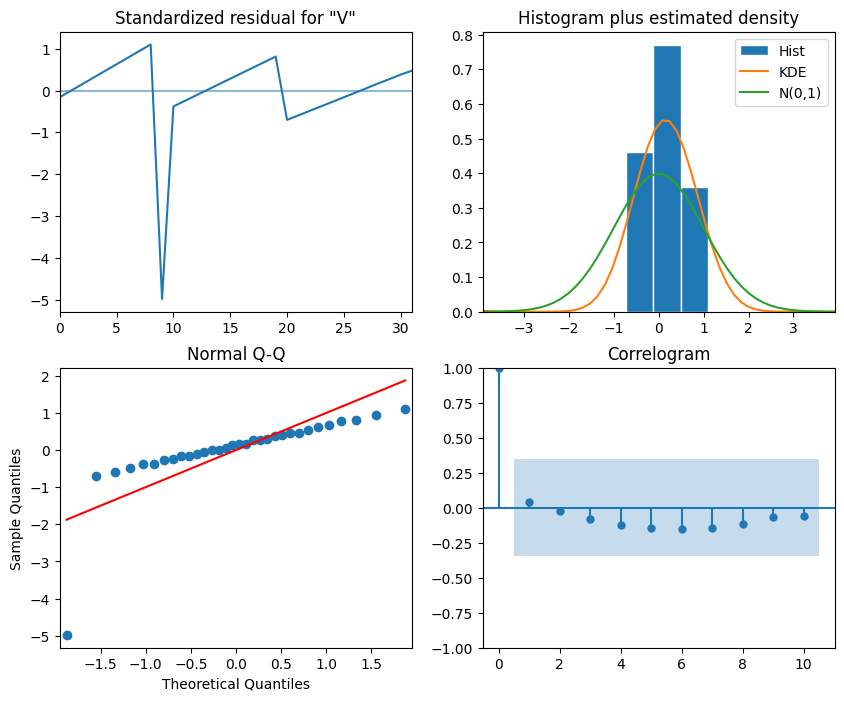

    Year      Value  pred_mean  pred_last_value  pred_ARMA
26  2016  31.620970  28.804963        31.439006  31.618808
27  2017  31.802934  28.804963        31.439006  31.795623
28  2018  31.984898  29.012605        31.802934  31.977586
29  2019  32.166970  29.012605        31.802934  32.149374
30  2020  32.348935  29.216827        32.166970  32.337712


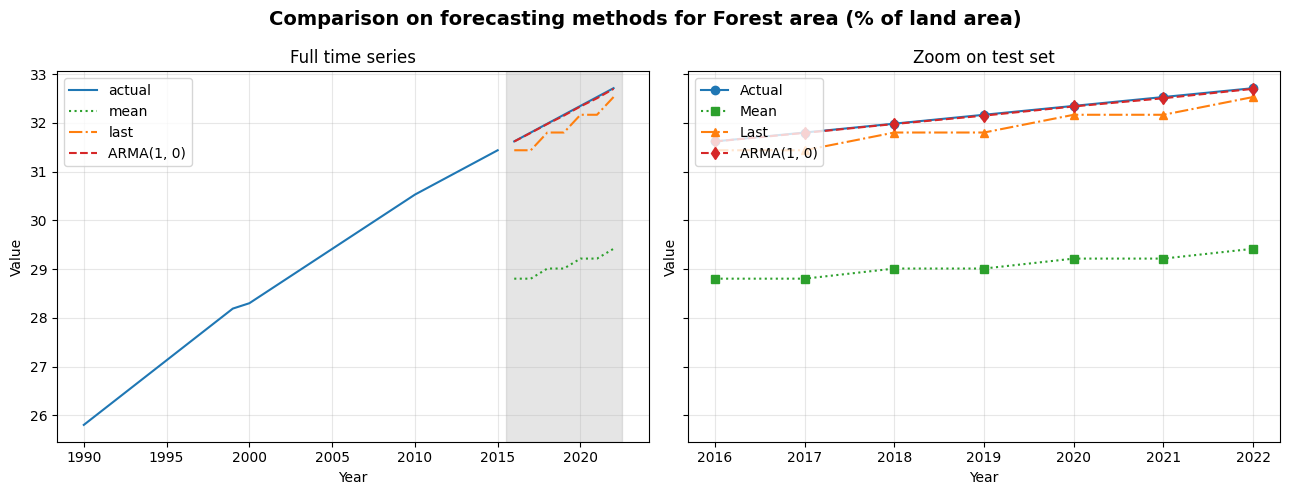

MAE -> mean: 3.097, last: 0.260, AR(2): 0.012
MSE -> mean: 9.621, last: 0.076, AR(2): 0.000


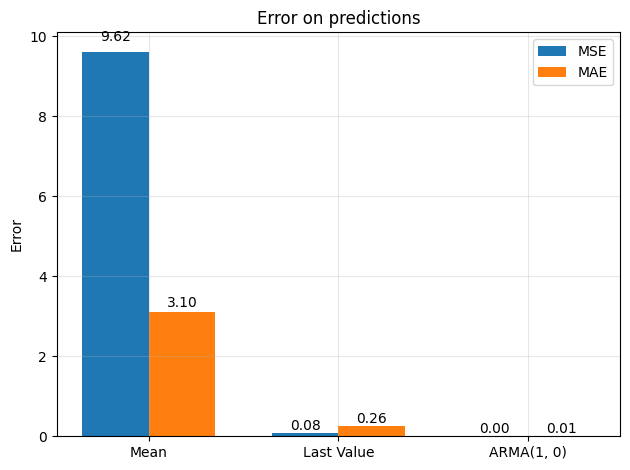

In [68]:
ps = range(0, 4, 1)
qs = range(0, 4, 1)
order_list = list(product(ps, qs))

indicators = df["Indicator Name"].unique()
for indicator in indicators:
    df_temp = (
        df[df["Indicator Name"] == indicator]
        .melt(id_vars=["Indicator Name"], var_name="Year", value_name="Value")
        .assign(Year=lambda d: d["Year"].astype(int))
        .dropna(subset=["Value"])
        [["Year", "Value"]]
        .reset_index(drop=True)
    )
    if df_temp.empty or len(df_temp) < 20 or df_temp['Value'].nunique() == 1:
        continue
    
    if (test_stationarity(df_temp['Value'])) :
        print("========================= STAZIONARIA ========================")
        print(indicator, len(df_temp), df_temp['Value'].var())
        result_df = optimize_ARMA(df_temp, order_list)
        if not result_df.empty:
            best_order = result_df.iloc[0]['(p,q)']
            best_aic = result_df.iloc[0]['AIC']
            print(f"Miglior ARMA{best_order} con AIC={best_aic:.3f}")
            p, q = best_order
            model = ARIMA(df_temp['Value'], order=(p, 0, q), enforce_stationarity=False, enforce_invertibility=False)
            fitted = model.fit()
            residuals = fitted.resid.dropna()
            # print(fitted.summary())
            plt.close('all')
            
            # QQ PLOT
            fig, ax = plt.subplots()
            qqplot(residuals, line='45', ax=ax)
            ax.set_title(f"QQ-plot residuals ARMA{(p, q)}")
            plt.tight_layout()
            plt.show()
            
            # PLOT DIAGNOSTICS
            fitted.plot_diagnostics(figsize=(10,8))
            plt.show()
            
            train = df_temp[:int(0.8*len(df_temp))]
            test = df_temp[int(0.8*len(df_temp)):]
            
            TRAIN_LEN = len(train)
            HORIZON = len(test)
            WINDOW = 2

            pred_mean = rolling_forecast(df_temp, TRAIN_LEN, HORIZON, WINDOW, 'mean', p, q)
            pred_last_value = rolling_forecast(df_temp, TRAIN_LEN, HORIZON, WINDOW, 'last', p, q)
            pred_ARMA = rolling_forecast(df_temp, TRAIN_LEN, HORIZON, WINDOW, 'ARMA', p, q)

            test = df_temp.iloc[TRAIN_LEN:TRAIN_LEN+HORIZON].copy()
            test['pred_mean'] = pred_mean[:HORIZON]
            test['pred_last_value'] = pred_last_value[:HORIZON]
            test['pred_ARMA'] = pred_ARMA[:HORIZON]
            print(test.head())
            
            fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(13,5))
            fig.suptitle(f"Comparison on forecasting methods for {indicator}", fontsize=14, fontweight="bold")
            ax1.plot(train['Year'], train['Value'])
            ax1.plot(test['Year'], test['Value'], color = colors[0], linestyle='-', label='actual')
            ax1.plot(test['Year'], test['pred_mean'], color = colors[1], linestyle=':', label='mean')
            ax1.plot(test['Year'], test['pred_last_value'], color = colors[2], linestyle='-.', label='last')
            ax1.plot(test['Year'], test['pred_ARMA'], color = colors[3], linestyle='--', label=f'ARMA{(p,q)}')
            ax1.legend(loc=2)
            ax1.set_title("Full time series")
            ax1.set_xlabel('Year')
            ax1.set_ylabel('Value')
            ax1.grid(True, alpha=0.3)
            start_year = int(test['Year'].iloc[0])
            end_year = int(test['Year'].iloc[-1])
            ax1.axvspan(start_year - 0.5, end_year + 0.5, color='#808080', alpha=0.2)
            
            ax2.plot(test['Year'], test['Value'], color = colors[0], linestyle='-', label='Actual', marker="o")
            ax2.plot(test['Year'], test['pred_mean'], color = colors[1], linestyle=':', label='Mean', marker="s")
            ax2.plot(test['Year'], test['pred_last_value'], color = colors[2], linestyle='-.', label='Last', marker="^")
            ax2.plot(test['Year'], test['pred_ARMA'], color = colors[3], linestyle='--', label=f'ARMA{(p,q)}', marker="d")
            ax2.legend(loc=2)
            ax2.set_title("Zoom on test set")
            ax2.set_xlabel('Year')
            ax2.set_ylabel('Value')
            ax2.grid(True, alpha=0.3)
            
            ax1.tick_params(labelbottom=True)
            ax2.tick_params(labelbottom=True) 
            plt.setp(ax2.get_xticklabels(), visible=True)
            plt.tight_layout()
            plt.show()
            
            # mae e mse a confronto
            mae_mean = mean_absolute_error(test['Value'], test['pred_mean'])
            mae_last = mean_absolute_error(test['Value'], test['pred_last_value'])
            mae_arma = mean_absolute_error(test['Value'], test['pred_ARMA'])

            mse_mean = mean_squared_error(test['Value'], test['pred_mean'])
            mse_last = mean_squared_error(test['Value'], test['pred_last_value'])
            mse_arma = mean_squared_error(test['Value'], test['pred_ARMA'])
            
            print(f"MAE -> mean: {mae_mean:.3f}, last: {mae_last:.3f}, AR(2): {mae_arma:.3f}")
            print(f"MSE -> mean: {mse_mean:.3f}, last: {mse_last:.3f}, AR(2): {mse_arma:.3f}")
            
            results = pd.DataFrame({
                'Method': ['Mean', 'Last Value', f'ARMA{(p,q)}'],
                'MSE': [mse_mean, mse_last, mse_arma],
                'MAE': [mae_mean, mae_last, mae_arma]
            })

            fig, ax = plt.subplots()
            x = np.arange(len(results['Method']))
            width = 0.35

            # GRAFICO MSE e MAE
            ax.bar(x - width/2, results['MSE'], width, label='MSE')
            ax.bar(x + width/2, results['MAE'], width, label='MAE')
            ax.set_xticks(x)
            ax.set_xticklabels(results['Method'])
            ax.set_title("Error on predictions")
            ax.set_ylabel("Error")
            ax.legend()
            ax.grid(alpha=0.3)

            for idx in x:
                ax.text(idx - width/2, results['MSE'][idx] + 0.02*(results['MSE'][idx]), f"{results['MSE'][idx]:.2f}", ha='center', va='bottom')
                ax.text(idx + width/2, results['MAE'][idx] + 0.02*(results['MAE'][idx]), f"{results['MAE'][idx]:.2f}", ha='center', va='bottom')

            plt.tight_layout()
            plt.show()

In [ ]:
# else:
    #     print("========================= NON STAZIONARIA ========================")      
    #     diff_count = 0
    #     current_series = df_temp['Value'].copy()
    #     while diff_count < 4:
    #         current_series = current_series.diff()
    #         result = adfuller(current_series.dropna())
    #         adf_stat, p_value = result[0], result[1]
    #         if p_value < 0.05:
    #             print(f"Serie stazionaria dopo {diff_count+1} differenziazioni.")
    #             df_temp['Diff'] = current_series
    #             print(best_arma_for_series(df_temp))
    #             break
    #         else:
    #             diff_count += 1